# LogisticRegression

## Import and Load Data Set

In [23]:
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from verstack.stratified_continuous_split import scsplit 

In [2]:
# Load the training data
train_data = pd.read_csv("data/train.csv")
train_data.head(3)

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
0,0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up
1,1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,"Most of us are Human Beings, but I think you m..."
2,2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,"Old dirty tricks Trump, at it again...like we ..."


In [3]:
train_data['retweet_count'].describe()

count    665777.000000
mean        147.687398
std        2972.051181
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      942572.000000
Name: retweet_count, dtype: float64

In [4]:
train_data['retweet_count'].value_counts()

0       422803
1        57111
2        25737
3        16338
4        11695
         ...  
2279         1
2468         1
4324         1
1765         1
5301         1
Name: retweet_count, Length: 6871, dtype: int64

## Preprocessing

In [5]:
class FeatureExtraction(object):

    def __init__(self, train_data):
        self.train_data = train_data
    
    def transform(self):
        train_data = self.train_data
        
        #user verified
        labelencoder=LabelEncoder()
        train_data['user_verified']=labelencoder.fit_transform(train_data['user_verified'])
        
        #timestamp
        train_data["user_hour"] = train_data.timestamp.apply(lambda t: (datetime.fromtimestamp(t//1000-5*3600)).hour)
        train_data["user_day"] = train_data.timestamp.apply(lambda t: (datetime.fromtimestamp(t//1000-5*3600)).weekday())
        train_data["user_month"] = train_data.timestamp.apply(lambda t: (datetime.fromtimestamp(t//1000-5*3600)).month)
        
        #number of hashtags
        train_data['totalhashtag'] = train_data['hashtags'].str.split().str.len()
        train_data['totalhashtag'] = train_data['totalhashtag'].fillna(0)
        train_data = train_data.drop(columns=['hashtags'])
        

        #number of mentions
        train_data['totalmentions'] = train_data['user_mentions'].str.split().str.len()
        train_data['totalmentions'] = train_data['totalmentions'].fillna(0)
        
        train_data = train_data.drop(columns=['user_mentions'])
        
        
        # urls
        train_data['urls'] = train_data['urls'].fillna(0)
        train_data = train_data.assign(urls=(train_data['urls'] !=0 ).astype(int))
        
      
        self.transformed_data = train_data
                                     
        pass

## Feature Extraction


In [6]:
y = train_data.retweet_count 
for i in range(train_data.shape[0]):
       if y[i] == 0:
            y[i] = 0
       elif y[i]>0 and y[i]<10:
            y[i] = 1
       elif y[i]>10 and y[i]<100:
            y[i] = 2
       elif y[i]>100 and y[i]<1000:
            y[i] = 3
       else:
            y[i] = 4

In [7]:
FE = FeatureExtraction(train_data)
FE.transform()
features = FE.transformed_data

In [8]:
X = features[["user_verified", "user_statuses_count", "user_followers_count", "user_friends_count","totalhashtag", "totalmentions","urls","user_hour","user_day","user_month"]]
X_train, X_test, y_train, y_test = scsplit(X, y, stratify=y, train_size=0.7,test_size=0.3)

## Logistic Regression

In [9]:
train_data_model = LogisticRegression()
train_data_model.fit(X_train,y_train)
y_pred=train_data_model.predict(X_test)

In [10]:
metrics.mean_absolute_error(y_test, y_pred)

0.4310883475021779

In [11]:
acc = accuracy_score(y_test,y_pred)
acc

0.6822724223216878

## Feature Correlation

In [12]:
y.describe()

count    665777.000000
mean          0.598619
std           0.956913
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           4.000000
Name: retweet_count, dtype: float64

In [25]:
X.describe()

,user_verified,user_statuses_count,user_followers_count,user_friends_count,totalhashtag,totalmentions,urls,user_hour,user_day,user_month
count,665777.000000,6.657770e+05,6.657770e+05,6.657770e+05,665777.000000,665777.000000,665777.000000,665777.000000,665777.000000,665777.000000
mean,0.133294,4.167295e+04,2.329881e+05,2.743131e+03,0.192219,0.129498,0.321549,12.528117,3.011354,4.921190
std,0.339892,9.848516e+04,2.442260e+06,1.725410e+04,0.694312,0.558951,0.467071,6.550916,2.196865,0.269442
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,0.000000,2.352000e+03,2.060000e+02,2.290000e+02,0.000000,0.000000,0.000000,8.000000,1.000000,5.000000
50%,0.000000,1.080400e+04,1.002000e+03,6.390000e+02,0.000000,0.000000,0.000000,13.000000,4.000000,5.000000
75%,0.000000,3.809900e+04,6.012000e+03,1.746000e+03,0.000000,0.000000,1.000000,18.000000,5.000000,5.000000
max,1.000000,7.203222e+06,1.170640e+08,4.399078e+06,18.000000,13.000000,1.000000,23.000000,6.000000,5.000000


In [19]:
datacorr = train_data.corr()
datacorr.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_hour,user_day,user_month,totalhashtag
id,1.000000,-0.000258,-0.000684,0.000932,0.000611,0.001433,0.002043,0.000113,-0.000872,-0.000906,0.001048
timestamp,-0.000258,1.000000,-0.007316,0.005081,0.004274,0.012339,0.002441,-0.010344,-0.583776,0.436845,-0.013471
retweet_count,-0.000684,-0.007316,1.000000,0.491130,0.119775,0.212395,0.108852,-0.027392,-0.059708,-0.081967,0.258830
user_verified,0.000932,0.005081,0.491130,1.000000,0.198346,0.235241,0.049641,-0.007619,-0.043877,-0.046219,0.093272
user_statuses_count,0.000611,0.004274,0.119775,0.198346,1.000000,0.172699,0.150665,0.014659,-0.016374,-0.024173,-0.001115


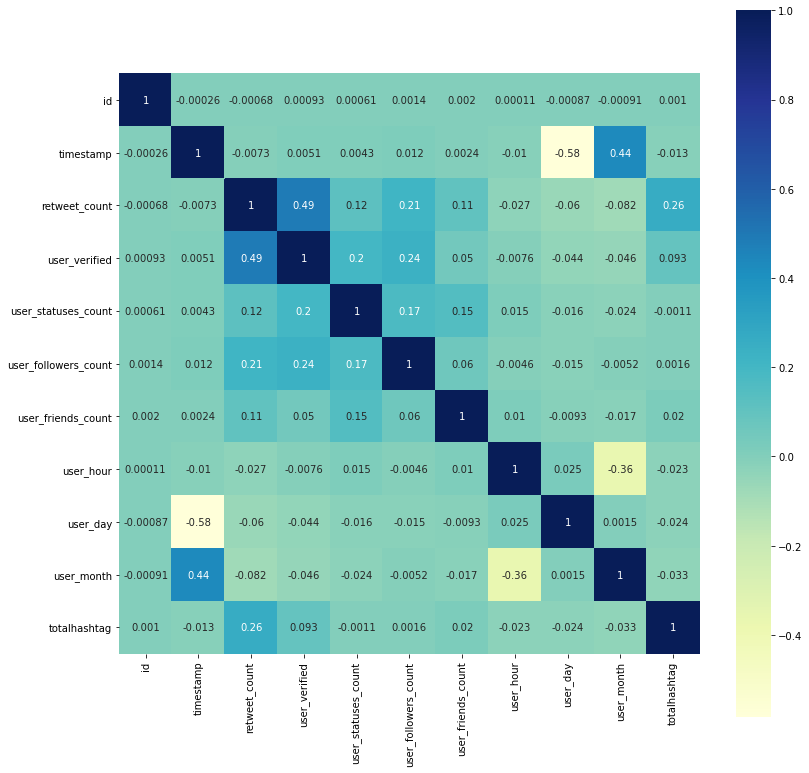

In [24]:
plt.figure(figsize = (13,13))
sns.heatmap(datacorr, cmap = 'YlGnBu',square=True,annot=True)

## Evaluation 

In [13]:
eval_data = pd.read_csv("data/evaluation.csv")
FE_eval = FeatureExtraction(eval_data)
FE_eval.transform()

In [14]:
trans_eval_data = FE_eval.transformed_data
X_eval = trans_eval_data.drop("text",axis=1)

In [15]:
sc = StandardScaler()
X_eval = sc.fit_transform(X_eval.values)

## Prediction for Logistic Regression

In [26]:
y_eval_pred_logistic = train_data_model.predict(X_eval)

ValueError: X has 12 features per sample; expecting 10

In [ ]:
with open("logistic_regression.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for index, prediction in enumerate(y_eval_pred_logistic):
        writer.writerow([str(trans_eval_data['id'].iloc[index]) , str(int(prediction))])